<a href="https://colab.research.google.com/github/k-kotera/my_code/blob/master/MLNN_shapelets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning Multivariate Shapelets with Multi-Layer Neural Networks
LTS(Learning Time-series Shapelets)では分類にロジスティクス回帰を用いるが、それをディープニューラルネットに置き換える。

#### 参考
①Roberto Medico, Joeri Ruyssinck, Dirk Deschrijver, Tom Dhaene.
Learning Multivariate Shapelets with Multi-Layer Neural Networks.
Advanced Course on Data Science & Machine Learning (ACDL) 2018.<br>
②Grabocka, J., Schilling, N., Wistuba, M. and SchmidtThieme, L.: Learning Time-series Shapelets, Proceedings of the 20th ACM SIGKDD International Conference on Knowledge Discovery and Data Mining, KDD
’14, ACM, pp. 392–401 (2014).


In [0]:
#使用するモジュール
from keras.models import Model
from keras import regularizers
from keras.layers import Dense, Conv1D, Layer, Input, BatchNormalization, Dropout
from keras.metrics import categorical_accuracy, categorical_crossentropy
from keras.utils import to_categorical
from keras.optimizers import Adam
import keras.backend as K
from keras.engine import InputSpec
import numpy as np
from scipy.io import arff
import matplotlib.pyplot as plt
import tensorflow as tf

from keras.initializers import Initializer
from tslearn.clustering import TimeSeriesKMeans
from tslearn.utils import to_time_series_dataset

### データを読み込み（事前にデータセットをカレントディレクトリに置くこと）

In [0]:
train_dataset, train_meta = arff.loadarff("ECGFiveDays_TRAIN.arff")
test_dataset, test_meta = arff.loadarff("ECGFiveDays_TEST.arff")

trds=np.asarray(train_dataset.tolist(), dtype=np.float32)
Len_data = trds.shape[1]

y_train=np.asarray(trds[:,Len_data-1].tolist(), dtype=np.int16)
X_train=trds[:, :Len_data-1]
teds=np.asarray(test_dataset.tolist(), dtype=np.float32)
y_test=np.asarray(teds[:,Len_data-1].tolist(), dtype=np.int16)
X_test=teds[:, :Len_data-1]

num_classes = len(set(y_train))

y_train_c = to_categorical(y_train-1, num_classes)
y_test_c = to_categorical(y_test-1, num_classes)

In [0]:
#正規化
from tslearn.preprocessing import TimeSeriesScalerMinMax
X_train_norm = TimeSeriesScalerMinMax().fit_transform(X_train)
X_test_norm = TimeSeriesScalerMinMax().fit_transform(X_test)

### カスタムレイヤーおよびカスタム初期化関数定義

In [0]:
class  SoftMinimum(Layer):
    def __init__(self, alpha = -100, **kwargs):
        self.alpha = alpha
        super(SoftMinimum, self).__init__(**kwargs)
        #self.input_spec = InputSpec(ndim=3)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[2]

    def call(self, inputs, **kwargs):
        E = tf.exp(self.alpha*inputs) + 1e-07
        Denom = tf.reduce_sum(E,axis=1)
        Numer = tf.reduce_sum(tf.multiply(E,inputs),axis=1)
        
        return tf.divide(Numer,Denom)
      

class GlobalMinPooling1D(Layer):
    def __init__(self, **kwargs):
        super(GlobalMinPooling1D, self).__init__(**kwargs)
        self.input_spec = InputSpec(ndim=3)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[2]

    def call(self, inputs, **kwargs):
        return K.min(inputs, axis=1)

class GlobalArgminPooling1D(Layer):
    def __init__(self, **kwargs):
        super(GlobalArgminPooling1D, self).__init__(**kwargs)
        self.input_spec = InputSpec(ndim=3)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[2]

    def call(self, inputs, **kwargs):
        return K.cast(K.argmin(inputs, axis=1), dtype=K.floatx())

class LocalSquaredDistanceLayer(Layer):
    def __init__(self, n_shapelets, X, **kwargs):
        self.n_shapelets = n_shapelets
        self.initializer = KMeansShapeletInitializer(X)
        super(LocalSquaredDistanceLayer, self).__init__(**kwargs)
        self.input_spec = InputSpec(ndim=3)

    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel',
                                      shape=(self.n_shapelets, input_shape[2]),
                                      initializer=self.initializer,
                                      trainable=True)
        super(LocalSquaredDistanceLayer, self).build(input_shape)

    def call(self, x, **kwargs):
        # (x - y)^2 = x^2 + y^2 - 2 * x * y
        x_sq = K.expand_dims(K.sum(x ** 2, axis=2), axis=-1)
        y_sq = K.reshape(K.sum(self.kernel ** 2, axis=1), (1, 1, self.n_shapelets))
        xy = K.dot(x, K.transpose(self.kernel))
        return x_sq + y_sq - 2 * xy

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[1], self.n_shapelets
      
      
      
def _kmeans_init_shapelets(X, n_shapelets, shp_len, n_draw=10000):
    n_ts, sz, d = X.shape
    indices_ts = np.random.choice(n_ts, size=n_draw, replace=True)
    indices_time = np.random.choice(sz - shp_len + 1, size=n_draw, replace=True)
    subseries = np.zeros((n_draw, shp_len, d))
    for i in range(n_draw):
        subseries[i] = X[indices_ts[i], indices_time[i]:indices_time[i] + shp_len]
    return TimeSeriesKMeans(n_clusters=n_shapelets,
                            metric="euclidean",
                            verbose=False).fit(subseries).cluster_centers_


class KMeansShapeletInitializer(Initializer):

    def __init__(self, X):
        self.X_ = to_time_series_dataset(X)

    def __call__(self, shape, dtype=None):
        n_shapelets, shp_len = shape
        shapelets = _kmeans_init_shapelets(self.X_,
                                           n_shapelets,
                                           shp_len)[:, :, 0]
        return K.tensorflow_backend._to_tensor(x=shapelets, dtype=K.floatx())

    def get_config(self):
        return {'data': self.X_}

def init_I(shape, dtype=None):
    weights_I = np.empty(shape,dtype=dtype)
    for di in range(shape[1]):
      weights_I[:, di, :] = np.eye(shape[2])
    return weights_I

### MLNN_shapeletsの実装

In [0]:
inputshape = X_train_norm.shape

sz = 15 #shapeletsの長さ
num_shapelet = 20 #shapeletsの数
input_shape = X_train_norm.shape #入力データのシェイプ

inputs = Input(shape=(input_shape[1], input_shape[2]), name="input")

#以下の3層が1つのDistanceLayer
x = Conv1D(filters=sz,
           kernel_size=sz,
           kernel_initializer=init_I,
           trainable=False,
           use_bias=False,
           name="DistanceLayer_1")(inputs)
x_loc = LocalSquaredDistanceLayer(num_shapelet,X=X_train_norm,name="DistanceLayer_2")(x)
x = SoftMinimum(name="DistanceLayer_3")(x_loc)

x = BatchNormalization()(x)
x = Dense(100, activation='relu', name = "hidden_1")(x)

x = BatchNormalization()(x)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation='softmax',kernel_regularizer=regularizers.l2(0.01), name = "output")(x)

s_model = Model(inputs=inputs, outputs=outputs)

In [0]:
out_loc = GlobalArgminPooling1D(name="for_loc_layer")(x_loc)
model_for_location = Model(inputs=inputs, outputs=out_loc)
model_for_location.compile(optimizer=Adam(), loss="mean_squared_error")#後でshapeletsのマッチング位置を確認するためのモデル

In [55]:
s_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 136, 1)            0         
_________________________________________________________________
DistanceLayer_1 (Conv1D)     (None, 122, 15)           225       
_________________________________________________________________
DistanceLayer_2 (LocalSquare (None, 122, 20)           300       
_________________________________________________________________
DistanceLayer_3 (SoftMinimum (None, 20)                0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 20)                80        
_________________________________________________________________
hidden_1 (Dense)             (None, 100)               2100      
_________________________________________________________________
batch_normalization_12 (Batc (None, 100)               400       
__________

DistanceLayerは3つまとめて論文のDistanceLayer。
1層目で入力データをスライディング窓サイズ=shapelets_lengthでずらし続けたものを並べて行列として出力。2層目は各shapeletに対する距離Dを計算。3層目でそれらのミニマムを取り、ニューラルネットへの入力であるMを得る。
以後は普通のDNN。

### モデルのコンパイルと学習

In [0]:
s_model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy',metrics=['accuracy'])

In [57]:
s_model.fit(X_train_norm,y_train_c, batch_size=23, epochs=20000,validation_data=(X_test_norm,y_test_c), verbose=0)

In [58]:
print("**** TRAIN ****")
print(list(zip(s_model.metrics_names, s_model.evaluate(X_train_norm,y_train_c, verbose=0))))
print("**** TEST ****")
print(list(zip(s_model.metrics_names, s_model.evaluate(X_test_norm,y_test_c, verbose=0))))

**** TRAIN ****
[('loss', 0.0003229734720662236), ('acc', 1.0)]
**** TEST ****
[('loss', 0.9349646740674141), ('acc', 0.8153310113529156)]


訓練データの精度は簡単に100%行きます。テストデータの精度はGlobalMinPooling1Dを使用で96%程度、SoftMinimum使用で80%～90%程度。


In [0]:
#モデルの保存
s_model.save_weights('MLNN_shapelets.h5')

In [0]:
#モデルの読み込み
s_model.load_weights('MLNN_shapelets.h5')

### shapeletの可視化

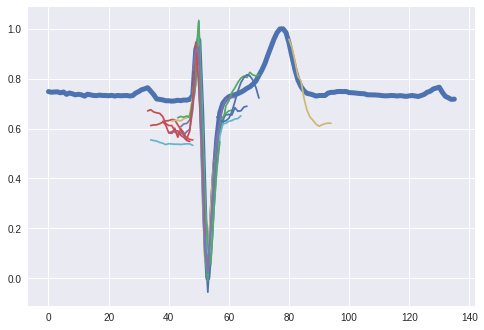

In [63]:
test_id = 60#テストデータのID
plt.plot(X_test_norm[test_id].ravel(), linewidth=5)


tst_shape = X_test_norm[test_id].shape

for i in range(0,15):
  shpn = i#shapeletのID
  shapelet_1 = np.array(model_for_location.get_layer("DistanceLayer_2").get_weights()).reshape(num_shapelet,sz)[shpn]
  loc1 = int(model_for_location.predict(X_test_norm[test_id].reshape(1,tst_shape[0],tst_shape[1])).ravel()[shpn])
  plt.plot(np.arange(loc1, loc1 + sz), shapelet_1)

In [64]:
model_for_location.predict(X_test_norm[test_id].reshape(1,tst_shape[0],tst_shape[1])).ravel()

array([56., 34., 44., 41., 34., 52., 47., 33., 40., 80., 50., 56., 43.,
       38., 48., 73., 53., 46., 69., 50.], dtype=float32)

全体的に50点目付近の形状の具合で分類の判断をされている模様

### 参考:普通のSVMでの精度

In [0]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler


clf = SVC(gamma='auto')
X_svm_trn = X_train.reshape(X_train.shape[0],X_train.shape[1])
X_svm_tst = X_test.reshape(X_test.shape[0],X_test.shape[1])
                                                      
scaler = StandardScaler()
scaler.fit(X_svm_trn)
                                                        
X_train_scaled = scaler.transform(X_svm_trn)
X_test_scaled = scaler.transform(X_svm_tst)
                                                      
clf.fit(X_train_scaled,y_train)
print(clf.score(X_train_scaled,y_train))
print(clf.score(X_test_scaled,y_test))

1.0
0.8397212543554007


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
cd drive/My Drive

/content/drive/My Drive


In [5]:
!pip install tslearn

    100% |████████████████████████████████| 593kB 24.0MB/s 
  Stored in directory: /root/.cache/pip/wheels/c6/7d/46/0428fa5dc53f09a5f776ea1fef7a5c5abd79ce07393e9ef52d
Successfully built tslearn
